In [228]:
!pip install textblob
!pip install gensim

from __future__ import division, print_function
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.merge import Add
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import numpy as np, pandas as pd
import os

from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
import numpy as np
import collections
import os
import pickle
from textblob import TextBlob
import re
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import matplotlib.pyplot as plt

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
DATA_DIR = "InferSent/encoder/data"
EMBED_SIZE = 4096
QA_TRAIN_FILE = "train.tsv"
QA_EMBED_SIZE = 64
BATCH_SIZE = 32
NBR_EPOCHS = 20
vocab_size = 5467

#####Pre-processing the data

In [286]:
train = pd.read_csv("InferSent/encoder/data/train.tsv",sep='\t')
train.head(3)

,ID,Question Stem,Choices,Complete Question,Answer Key
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C


In [333]:
#Create new features from the answer choices  
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    train.set_value(index,'OptionA',ans[1])
    train.set_value(index,'OptionB',ans[3])
    train.set_value(index,'OptionC',ans[5])
    train.set_value(index,'OptionD',ans[7])
    
#Find the answer key and replace it with the value   
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    if row['Answer Key'] == 'A':
        train.set_value(index,'Result',ans[1])
    elif row['Answer Key'] == 'B':
        train.set_value(index,'Result',ans[3])
    elif row['Answer Key'] == 'C':
        train.set_value(index,'Result',ans[5])
    elif row['Answer Key'] == 'D':
        train.set_value(index,'Result',ans[7])     

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWar

In [334]:
train = train.drop(['ID', 'Choices', 'Complete Question','Answer Key'], axis=1)

In [335]:
train.head(3)

,Question Stem,OptionA,OptionB,OptionC,OptionD,Result
0,The sun is responsible for,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting","plants sprouting, blooming and wilting"
1,When standing miles away from Mount Rushmore,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,the mountains seem smaller than in photographs
2,When food is reduced in the stomach,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works,nutrients are being deconstructed


In [336]:
#Split question, candidate answers and right answer to test and train data 
X_Question = train[train.columns[0:1]]
X_Answers = train[train.columns[1:5]]
Y = train.iloc[:,-1]
X_Question_train, X_Question_test,X_Answers_train,X_Answers_test,Y_train, Y_test = train_test_split(X_Question,X_Answers,Y, test_size=0.30)
print(X_Question_train.shape ,X_Question_test.shape, X_Answers_train.shape, X_Answers_test.shape,Y_train.shape,Y_test.shape)

(3469, 1) (1488, 1) (3469, 4) (1488, 4) (3469,) (1488,)


In [337]:
Y_train.head(3)

3641                  an ice pack 
784      a candle and a matchstick
2951                       seasons
Name: Result, dtype: object

In [100]:
question_maxlen = max([len(X_Question) for q in X_Question])
answer_maxlen = max([len(X_Answers) for a in X_Answers])
seq_maxlen = max([question_maxlen, answer_maxlen])
print(seq_maxlen)

4957


In [ ]:
embeddings_index = dict()
f = open('InferSent/dataset/GloVe/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

In [128]:
#Tokenise the question texts
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['Question Stem'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords


[['sun', 'responsible'], ['standing', 'miles', 'away', 'mount', 'rushmore'], ['food', 'reduced', 'stomach'], ['stars'], ['make', 'telescope']]


In [164]:
#Tokenise the answertext
lines_without_stopwords_answers=[] 
for line in train['Choices'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords_answers.append(new_line)
answer_texts = lines_without_stopwords

In [498]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.initializers import Constant
from keras.layers import Dense,Dropout,LSTM,Dropout, Activation,Add,BatchNormalization,dot,Input,concatenate


In [304]:
#Generate Question Embedding Matrix
train = pd.read_csv("InferSent/encoder/data/train.tsv",sep='\t')

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 15
t = Tokenizer(num_words=MAX_NUM_WORDS)
t.fit_on_texts(train['Question Stem'])
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index)) 

# integer encode the questions
encoded_docs = t.texts_to_sequences(train['Question Stem'])
# pad documents to a max length of 100 words
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))


for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    


Found 5466 unique tokens.


In [331]:
#Generate Answer Embedding Matrix

t_ans = Tokenizer(num_words=MAX_NUM_WORDS)
t_ans.fit_on_texts(train['Choices'])
word_index_ans = t_ans.word_index
print('Found %s unique tokens.' % len(word_index_ans)) 

# integer encode the questions
encoded_docs_ans = t_ans.texts_to_sequences(train['Choices'])
# pad documents to a max length of 100 words
padded_docs_ans = pad_sequences(encoded_docs_ans, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS = embeddings_index.get('a').shape[0]
num_words_ans = min(MAX_NUM_WORDS, len(word_index_ans)) + 1
embedding_matrix_ans = np.zeros((num_words_ans, EMBEDDING_DIM_ANS))


for word, i in word_index_ans.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans[i] = embedding_vector_ans



Found 8533 unique tokens.


In [204]:
#Create an Embedding layer for both question and answers 
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer_questions = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


embedding_layer_answers = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_ans),
                            input_length=MAX_SEQUENCE_LENGTH,mask_zero=True,
                            trainable=False)

(5467, 300)


Text(0.5,1,'example vectors')

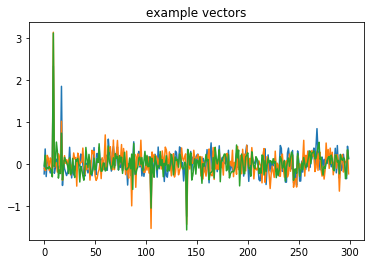

In [176]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

(8534, 300)


Text(0.5,1,'example vectors')

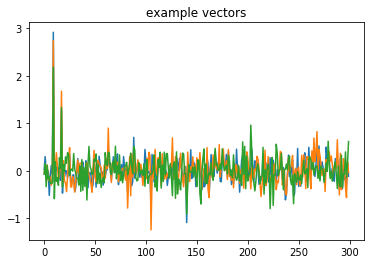

In [178]:
print(embedding_matrix_ans.shape)
plt.plot(embedding_matrix[15])
plt.plot(embedding_matrix[36])
plt.plot(embedding_matrix[20])
plt.title('example vectors')

In [238]:
# print("Building model...")
# qenc = Sequential()
# qenc.add(embedding_layer_questions)
# qenc.add(LSTM(EMBEDDING_DIM,input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=False))
# qenc.add(Dropout(0.3))

# aenc = Sequential()
# aenc.add(Embedding(output_dim=EMBEDDING_DIM, input_dim=len(word_index_ans)+1,
#                    weights=[embedding_matrix_ans], mask_zero=True))
# aenc.add(LSTM(EMBEDDING_DIM,input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=False))
# aenc.add(Dropout(0.3))

# model = Sequential()
# model.add(Concatenate([qenc, aenc]))
# model.add(Dense(2, activation="softmax"))
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


Building model...


In [468]:
#Simple Model with a single input and single hidden layer
model = Sequential()
e = Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=15, trainable=False)
model.add(e)
model.add(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(15, activation='softmax'))


In [469]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_117 (Embedding)    (None, 15, 300)           1640100   
_________________________________________________________________
lstm_96 (LSTM)               (None, 200)               400800    
_________________________________________________________________
dense_31 (Dense)             (None, 15)                3015      
Total params: 2,043,915
Trainable params: 403,815
Non-trainable params: 1,640,100
_________________________________________________________________
None


In [544]:
#Generate training data for the model 
training_idx = np.random.randint(padded_docs.shape[0], size=100)
test_idx = np.random.randint(padded_docs.shape[0], size=30)

training_idx_answers = np.random.randint(padded_docs_ans.shape[0], size=100)
test_idx_answers = np.random.randint(padded_docs_ans.shape[0], size=30)


training_Q, test_Q = padded_docs[training_idx,:], padded_docs[test_idx,:]

training_A, test_A = padded_docs_ans[training_idx,:], padded_docs_ans[test_idx,:]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [526]:
#model.fit(training_Q,training_A, epochs=100)

In [472]:
loss,acc= model.evaluate(test_Q, test_A, verbose=0)
print(acc*100,loss)

3.333333507180214 36207.453125


In [482]:
#model.predict(test_Q)

In [562]:
#QA LSTM
question_input = Input(training_idx.shape)
embedded_question = Embedding(len(word_index)+1, output_dim=300, weights=[embedding_matrix], input_length=15 ,trainable=False)(question_input)
encoded_question = LSTM(300)(embedded_question)

answer_input = Input(training_idx_answers.shape)
embedded_answer = Embedding(len(word_index_ans)+1, output_dim=300, weights=[embedding_matrix_ans], input_length=15 ,trainable=False)(answer_input)
encoded_answer = LSTM(300)(embedded_answer)

merged = concatenate([encoded_question, encoded_answer])
#output = Dense(1000, activation='softmax')(merged)

# This is our final model:
#qa_model = Model(inputs=[question_input, answer_input], outputs=output)




In [529]:
qa_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(qa_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_152 (Embedding)       (None, 15, 300)      1640100     input_37[0][0]                   
__________________________________________________________________________________________________
embedding_153 (Embedding)       (None, 15, 300)      2560200     input_38[0][0]                   
__________________________________________________________________________________________________
lstm_130 (

In [563]:
question_input

<tf.Tensor 'input_53:0' shape=(?, 100) dtype=float32>

In [539]:
qa_model.fit([training_Q,training_A], epochs=100)

ValueError: Error when checking input: expected input_37 to have shape (70,) but got array with shape (15,)

In [416]:
loss,acc= model2.evaluate(test_Q, test_A, verbose=0)
print(acc*100,loss)

7.333334535360336 -10737.939453125
